In [2]:
from __future__ import division
import sys, os
tag = 2
decay = "emu"

import matplotlib as mpl
#mpl.use('Agg') #use for python script mode
import matplotlib.pyplot as plt
#plt.ioff()

In [3]:
output_dir = 'gridscan_output/{0}/{1}'.format(decay, tag)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
plots_dir = 'plots/{0}/{1}'.format(decay, tag)
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)
classifiers_dir = 'classifiers/'.format(decay, tag)
if not os.path.exists(classifiers_dir):
    os.makedirs(classifiers_dir)

In [4]:
import numexpr
import os
import root_numpy
import ROOT
import cuts
from getdata.getdata import getData
import pandas as pd
from rep import utils
from sklearn.ensemble import GradientBoostingClassifier
from rep.report.metrics import RocAuc, OptimalSignificance
from tools.PunziFOM import OptimalPunziFOM
from rep.metaml import GridOptimalSearchCV, FoldingScorer, ClassificationFoldingScorer, RandomParameterOptimizer, SubgridParameterOptimizer
from rep.estimators import SklearnClassifier, TMVAClassifier, XGBoostRegressor, XGBoostClassifier #,TheanetsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from rep.metaml import RegressionParameterOptimizer, RandomParameterOptimizer, FoldingClassifier
from sklearn.gaussian_process import GaussianProcess
from rep.report.metrics import OptimalMetric, ams
from sklearn.metrics import roc_curve, auc
import numpy as np
from sklearn.utils import check_array, check_consistent_length
from sklearn.utils.multiclass import type_of_target
from scipy.stats import randint, uniform
import random
import re
from tools.findcuts import findcuts2
from vars_db import vars_db
default_stdout = sys.stdout #I need this to redirect the stdout back on screen at the end

Welcome to JupyROOT 6.08/06
-------------------------
Set LHCb Style - Feb 2012
-------------------------


/cvmfs/lhcb.cern.ch/lib/lcg/releases/ROOT/6.08.06-c8fb4/x86_64-slc6-gcc49-opt/lib/ROOT.py:417: UserWarning: "from ROOT import *" is not supported under IPython
  warnings.warn( '"from ROOT import *" is not supported under IPython' )
/eos/user/g/gandreas/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
branches = []
for branch in vars_db:
    if (vars_db[branch]['considered_for_MVA']):
        branches.append(branch)
        
additional_branches = ['Lb_M', 'eventNumber'] #spectator variables and others

In [6]:
 #get kerberos token for eos
import getpass
os.system("echo %s | kinit gandreas@CERN.CH" %getpass.getpass()) 

········


0

Password for gandreas@CERN.CH: 


In [7]:
#%time
#get data and mc trees
from Lb2LemuEnv import xroot
MC_tree = ROOT.TChain('Lb2LemuTuple/DecayTree')
MC_tree.Add(xroot+os.getenv("GUIDOANAEOSLOC")+"tuples/S28/MC/Lb_Lemu_MC_2016_M*.root")

data_tree = ROOT.TChain('Lb2LemuTuple/DecayTree')
#temporary fix:
#from glob import glob
#data_tree.AddFile(xroot+os.getenv("LBMICKJOBLOC")+"209/0/DVNtuple.root")
#data_tree.AddFile(xroot+os.getenv("LBMICKJOBLOC")+"209/1/DVNtuple.root")
#data_tree.AddFile(xroot+os.getenv("LBMICKJOBLOC")+"209/2/DVNtuple.root")
#data_tree.AddFile(xroot+os.getenv("LBMICKJOBLOC")+"209/3/DVNtuple.root")

#for file in glob(xroot+os.getenv("LBMICKJOBLOC")+"209/[0-9]/DVNtuple.root"):
#    data_tree.AddFile(file)
#for file in glob(xroot+os.getenv("LBMICKJOBLOC")+"210/[0-9]/DVNtuple.root"):
#    data_tree.AddFile(file)

data_tree = getData(['Lb2LemuTuple/DecayTree'], dtype = 'CL16_S28')['Lb2LemuTuple/DecayTree']

#de-activate not needed branches since otherwise the tree will be very heavy to handle
#data_tree['Lb2LemuTuple/DecayTree'].SetBranchStatus('*', 0)
#for branch in branches+additional_branches:#
#    data_tree['Lb2LemuTuple/DecayTree'].SetBranchStatus(branch, 1)
#data_tree['Lb2LemuTuple/DecayTree'].SetBranchStatus("Lb_M", 1)



Looking for /eos/lhcb/user/m/mmulder/ganga/209/*/DVNtuple.root
Trying to connect to EOS remotely
Looking for /eos/lhcb/user/m/mmulder/ganga/210/*/DVNtuple.root
Trying to connect to EOS remotely


In [8]:
#convert tree ntuples in train and test data with respectivle lables, under the form of pandas datasets
from tools.convert_data import convert_data

signal_training_cut = cuts.Lb_Lemu_matching+cuts.Lb_Lemu_trigger_run1_full

#print signal_training_cut.GetTitle()
train_data, train_labels, test_data, test_labels = convert_data (MC_tree,
                                                                 (cuts.Lb_Lemu_HOP_FD_cut+cuts.Lb_Lemu_matching+cuts.Lb_Lemu_trigger_run2_full_for_MVA_training).GetTitle(),
                                                                 data_tree,
                                                                 (cuts.Lb_Lemu_HOP_FD_cut+cuts.Lb_Lemu_sidebands+cuts.Lb_Lemu_trigger_run2_full_for_MVA_training).GetTitle(),
                                                                 branches+additional_branches,
                                                                 test_frac = 0.2)

#let's also prepare signal and background in separate dataframes for convenience
train_data_with_labels = pd.DataFrame(np.hstack((train_data, train_labels.reshape(train_labels.shape[0], -1))),
                  columns=branches+additional_branches+['labels'])
test_data_with_labels = pd.DataFrame(np.hstack((test_data, test_labels.reshape(test_labels.shape[0], -1))),
                  columns=branches+additional_branches+['labels'])

train_data_signal_with_labels = train_data_with_labels.loc[train_data_with_labels['labels']>0.5]
train_data_background_with_labels = train_data_with_labels.loc[train_data_with_labels['labels']<0.5]
test_data_signal_with_labels = test_data_with_labels.loc[test_data_with_labels['labels']>0.5]
test_data_background_with_labels = test_data_with_labels.loc[test_data_with_labels['labels']<0.5]

In [9]:
#X-check
ntrs = train_data_signal_with_labels.shape[0]
ntes = test_data_signal_with_labels.shape[0]
ntrb = train_data_background_with_labels.shape[0]
nteb = test_data_background_with_labels.shape[0]

print "Number of training signal events: ", ntrs
print "Number of training background events: ", ntrb
print "Number of test signal events: ", ntes
print "Number of test background events: ", nteb
print ""
print "Test fraction for signal: ", ntes/(ntrs+ntes)
print "Test fraction for background: ", nteb/(ntrb+nteb)

Number of training signal events:  1891
Number of training background events:  71382
Number of test signal events:  490
Number of test background events:  17829

Test fraction for signal:  0.205795884082
Test fraction for background:  0.199852036184


In [10]:
#fraction of signal events in sidebands
tot = MC_tree.GetEntries((cuts.Lb_Lemu_matching+cuts.Lb_Lemu_trigger_run2_full).GetTitle())
side = MC_tree.GetEntries((cuts.Lb_Lemu_matching+cuts.Lb_Lemu_trigger_run2_full+cuts.Lb_Lemu_sidebands).GetTitle())
side = MC_tree.GetEntries((cuts.Lb_Lemu_matching+cuts.Lb_Lemu_trigger_run2_full+cuts.Lb_Lemu_sidebands).GetTitle())
print "Percentage of signal events in sidebands (normalised to total signal events after trigger cuts):", 100.*side/tot, "%"

rside = MC_tree.GetEntries((cuts.Lb_Lemu_matching+cuts.Lb_Lemu_trigger_run2_full+cuts.Lb_Lemu_right_sideband).GetTitle())
print "Percentage of signal events in right sideband (normalised to total signal events after trigger cuts):", 100.*rside/tot, "%"

Percentage of signal events in sidebands (normalised to total signal events after trigger cuts): 7.67857142857 %
Percentage of signal events in right sideband (normalised to total signal events after trigger cuts): 0.584415584416 %


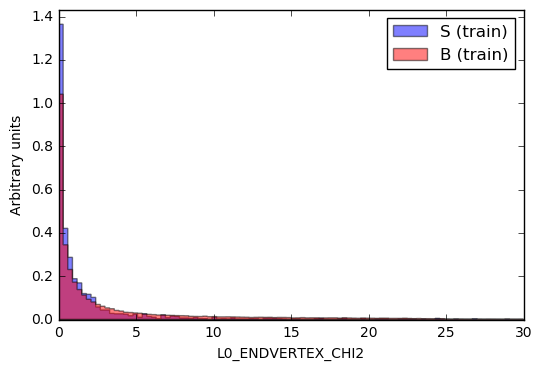

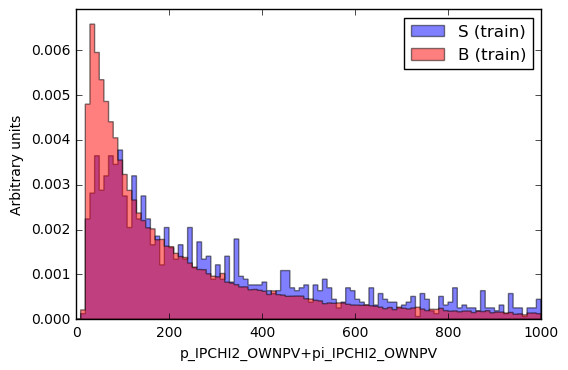

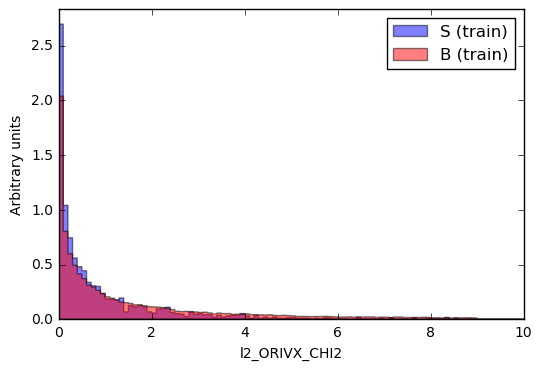

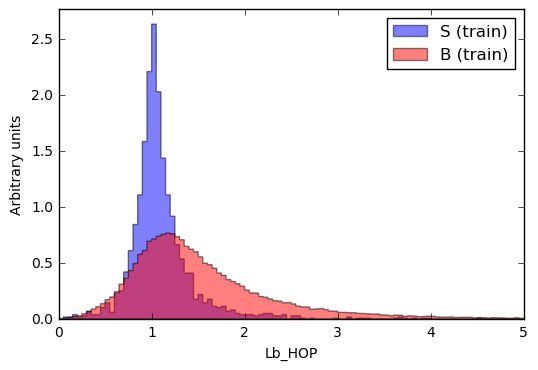

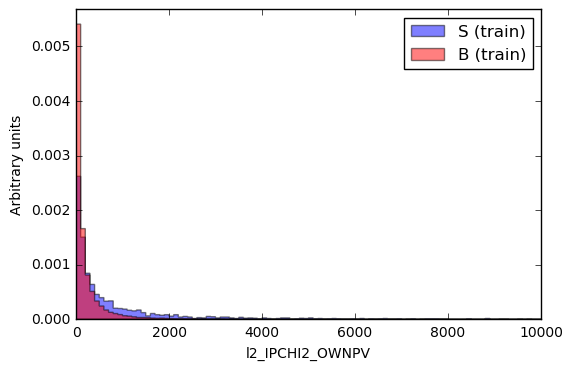

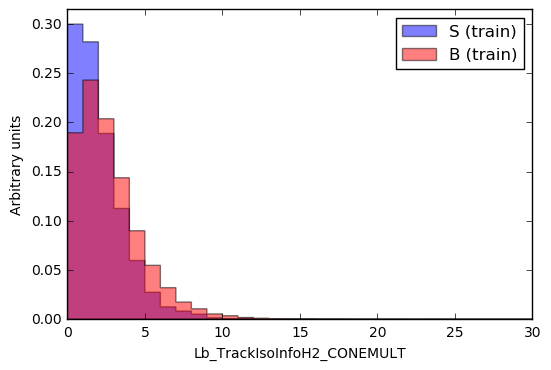

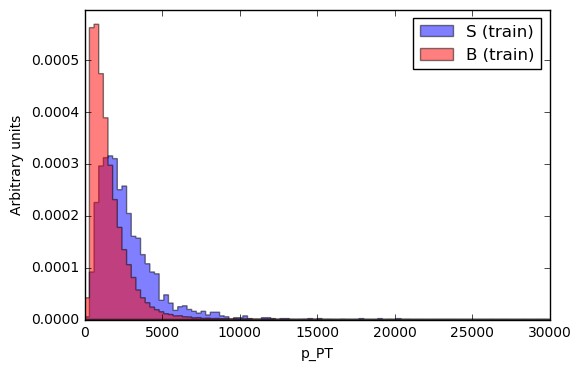

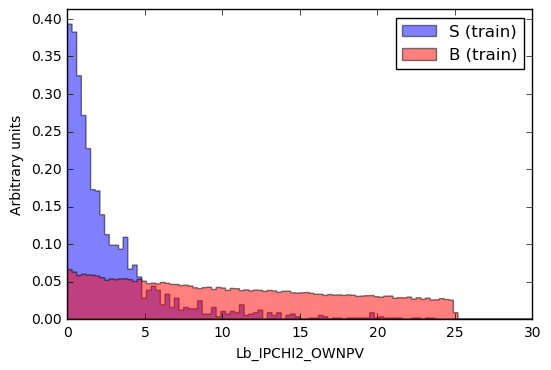

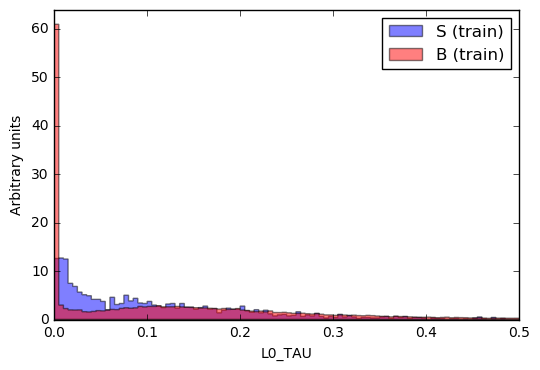

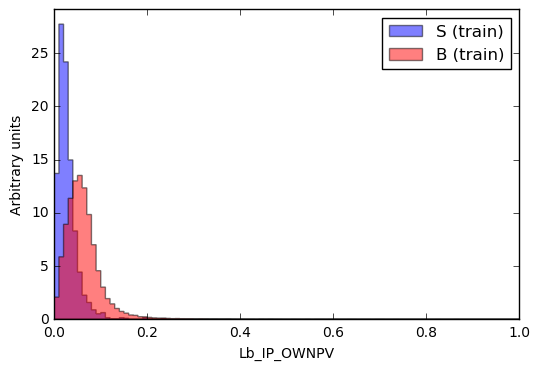

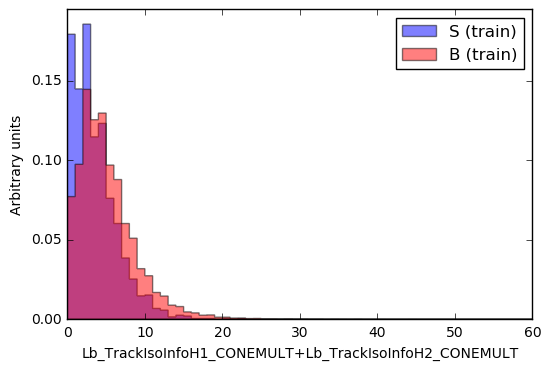

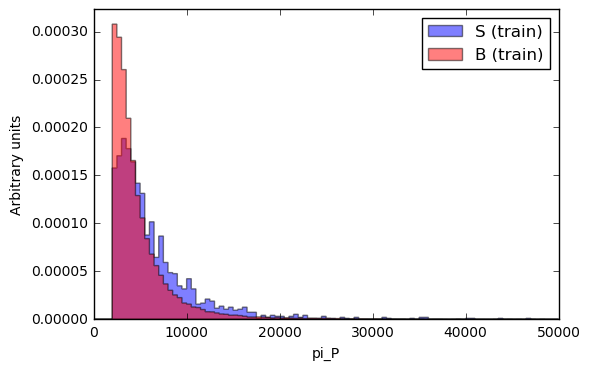

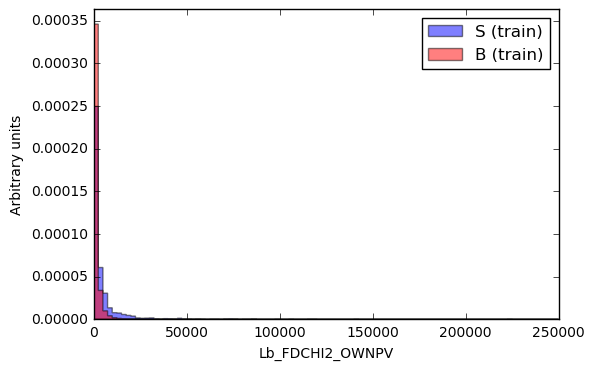

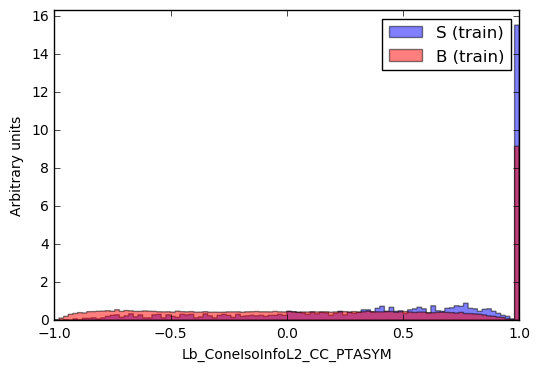

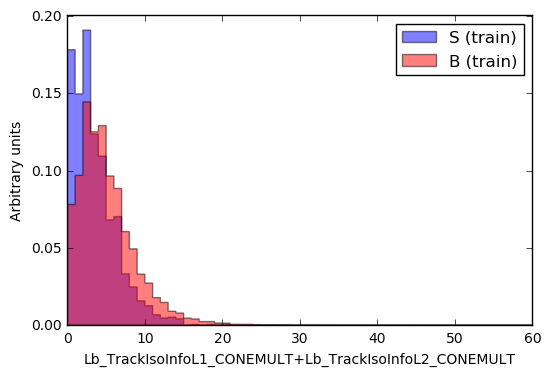

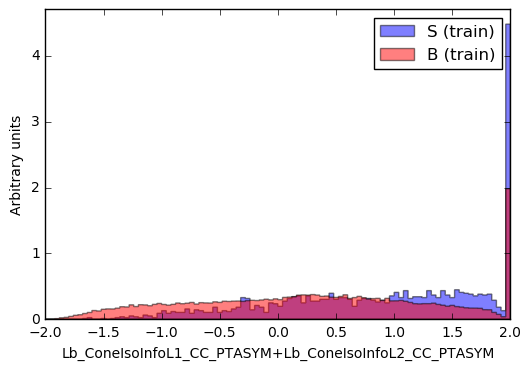

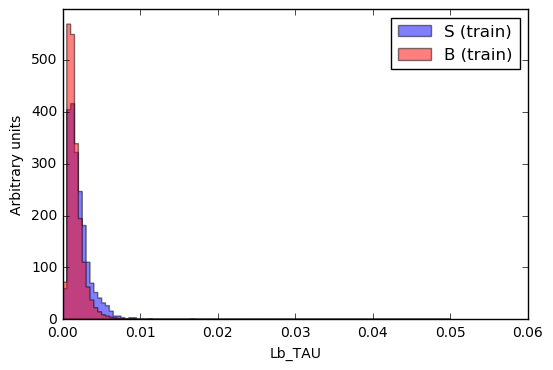

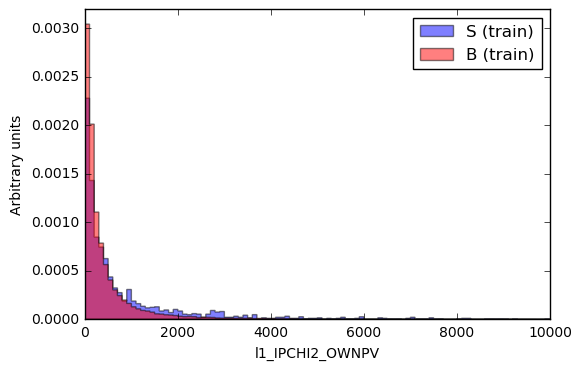

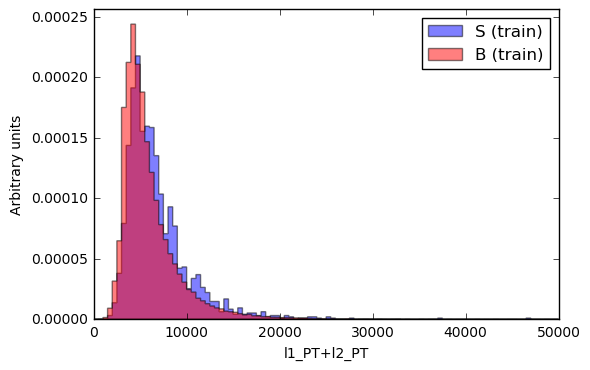

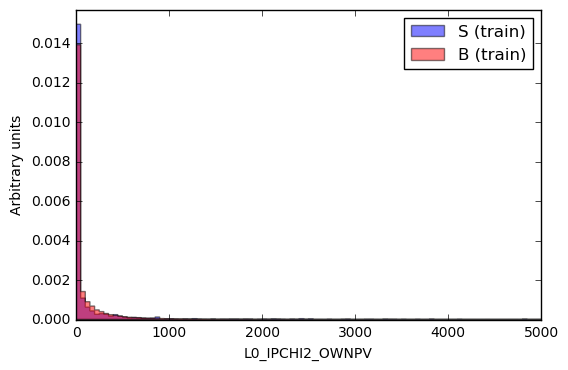

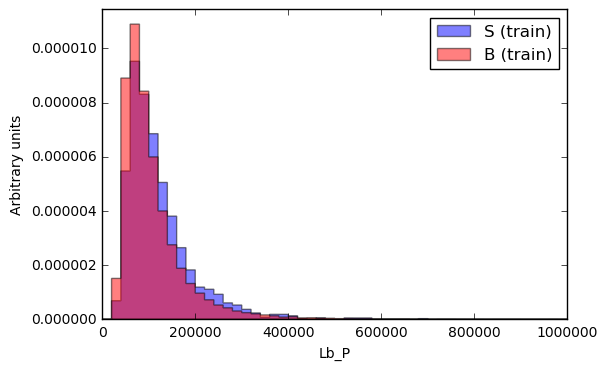

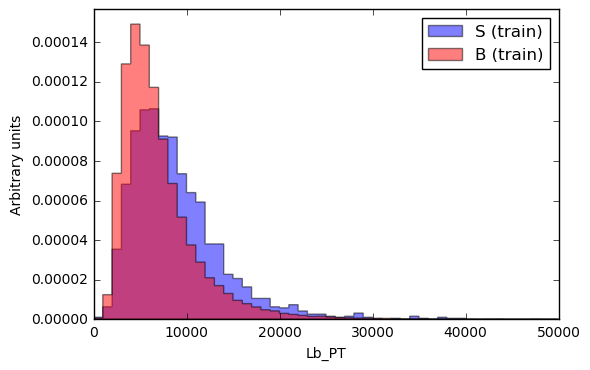

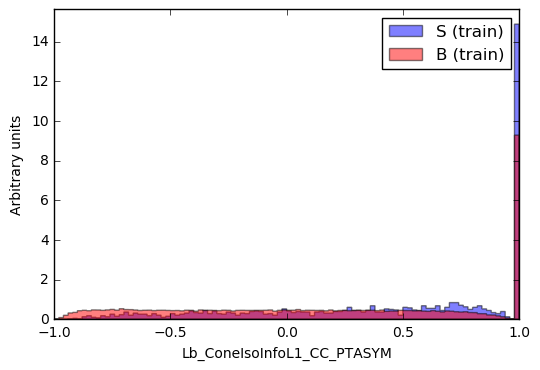

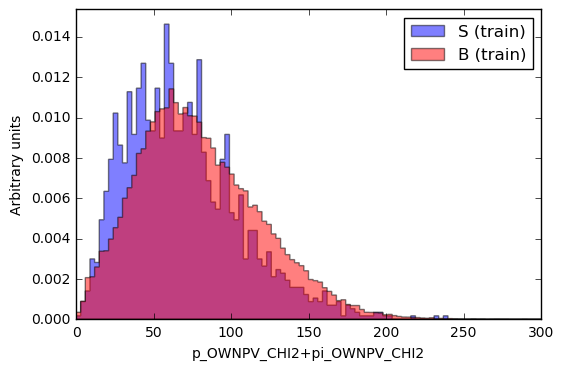

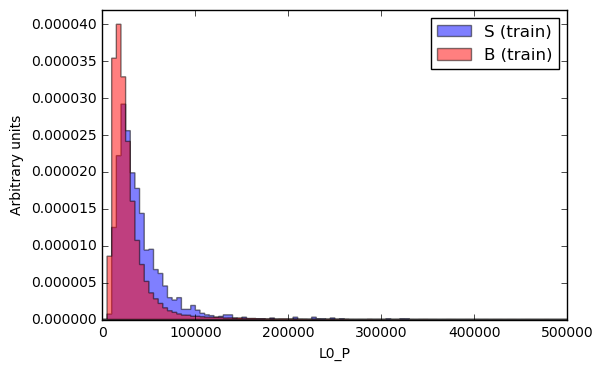

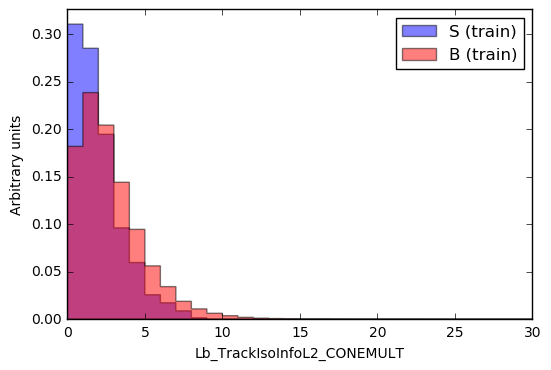

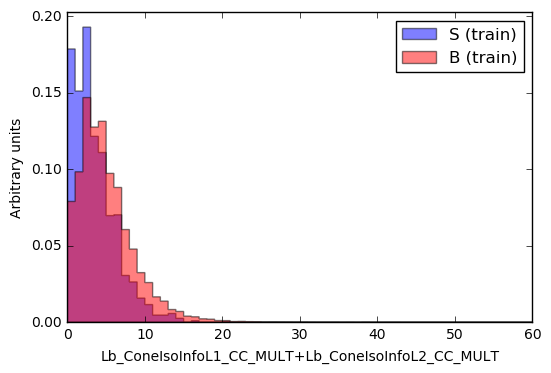

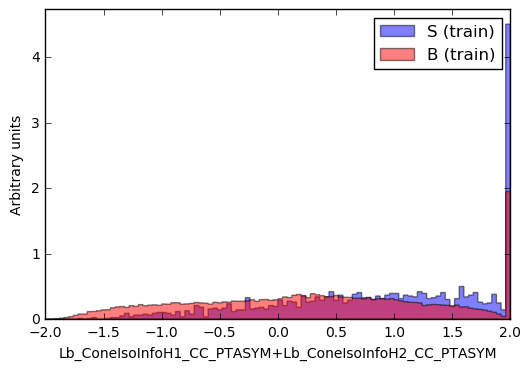

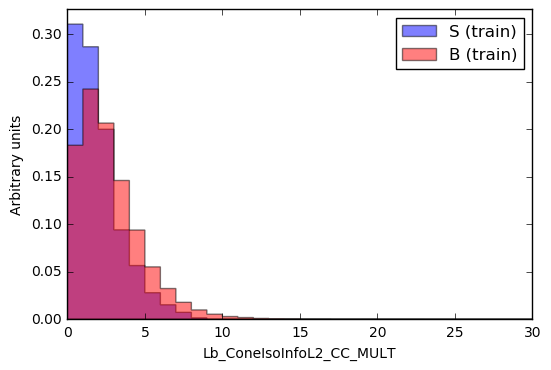

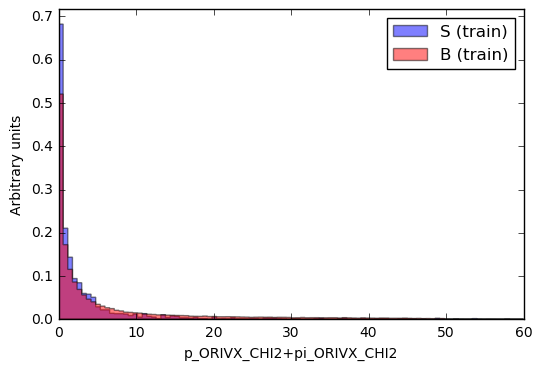

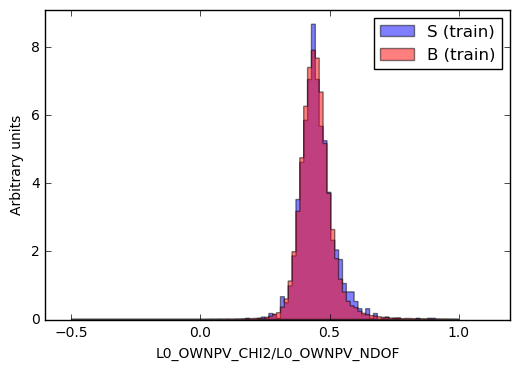

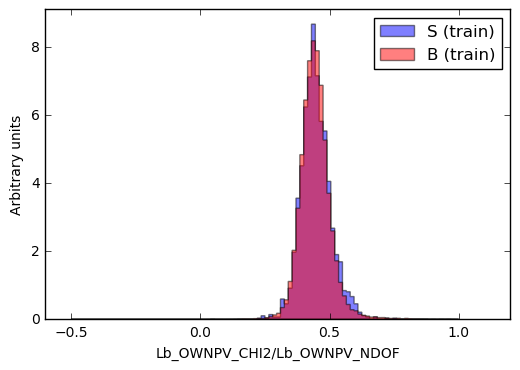

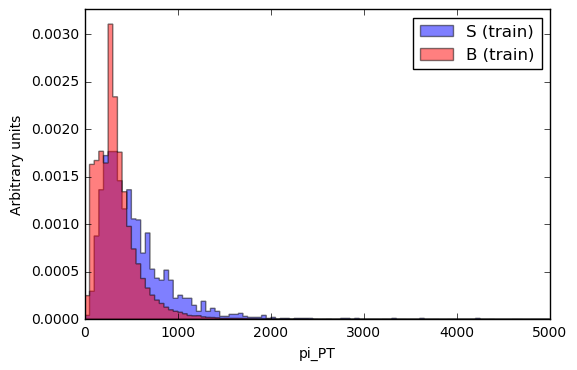

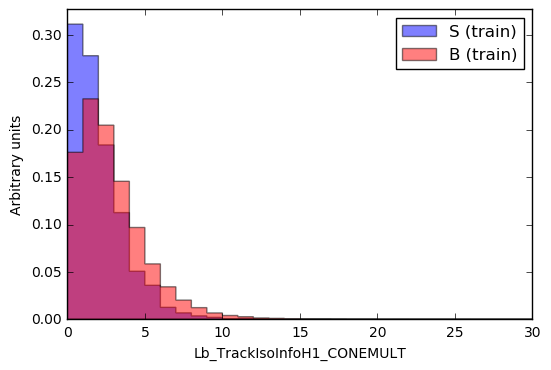

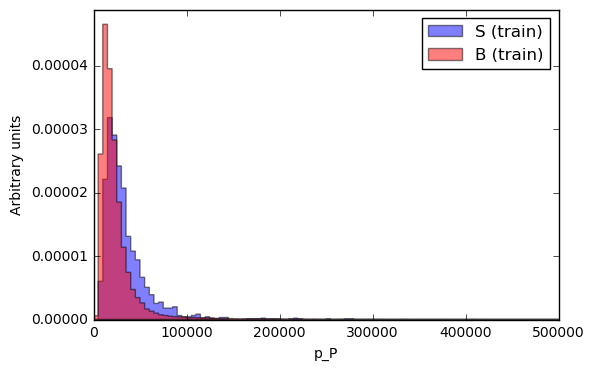

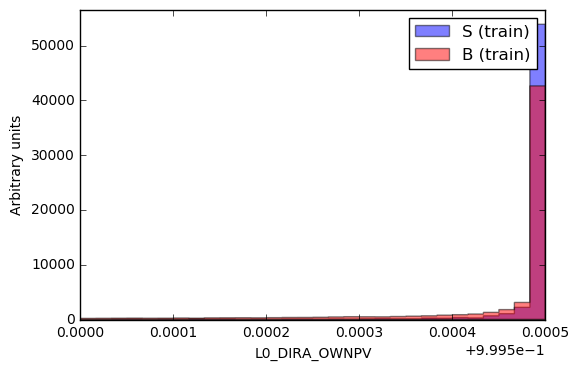

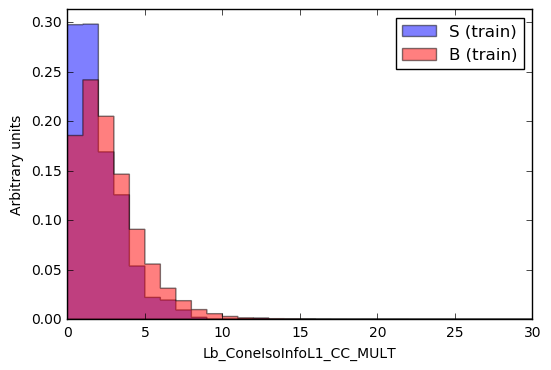

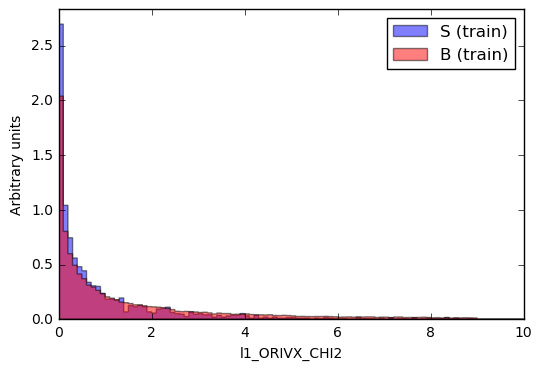

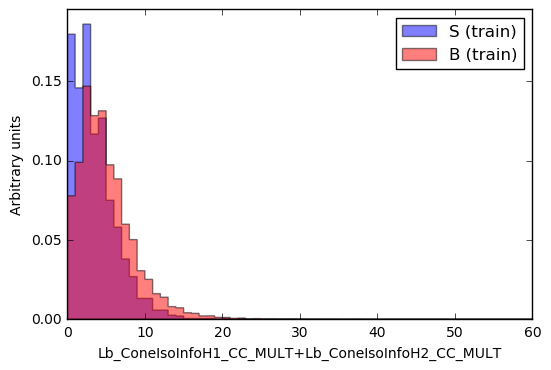

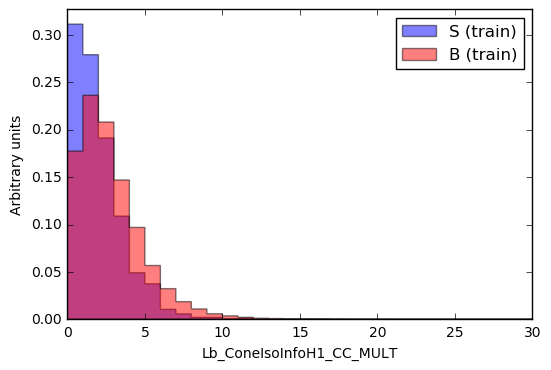

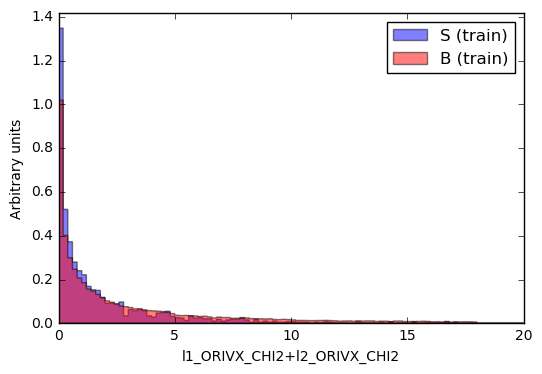

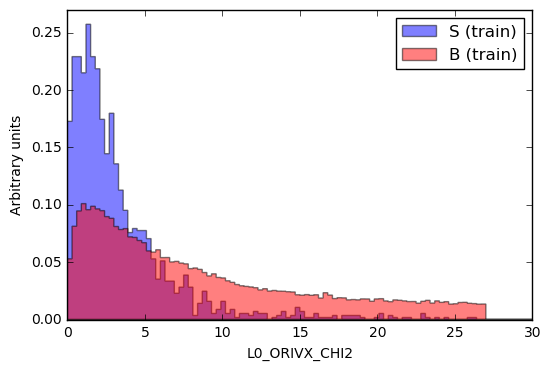

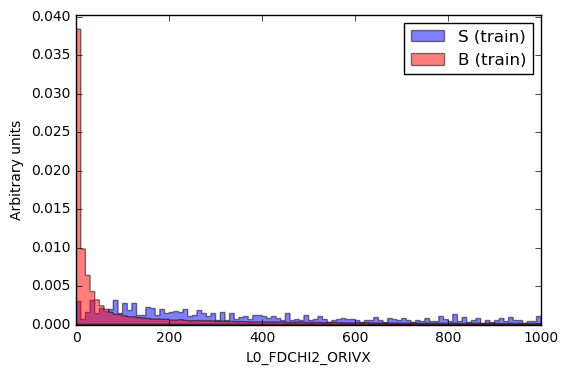

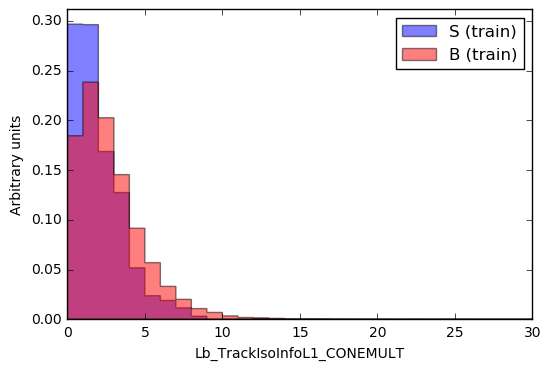

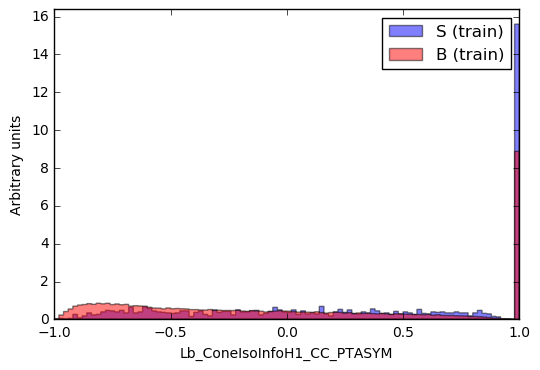

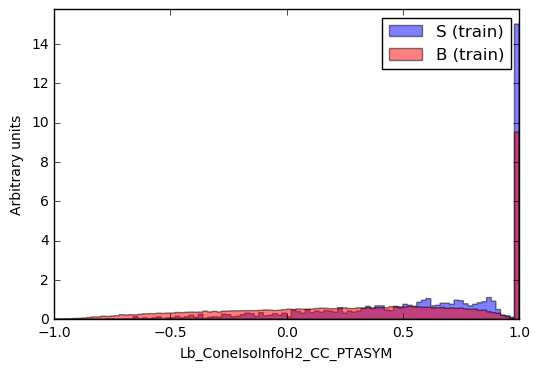

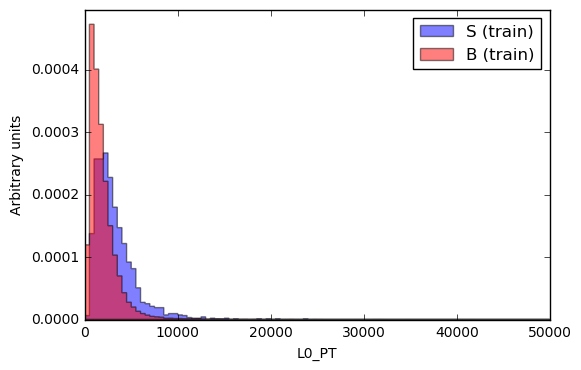

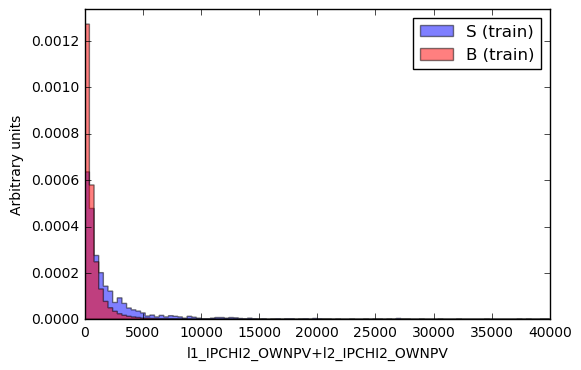

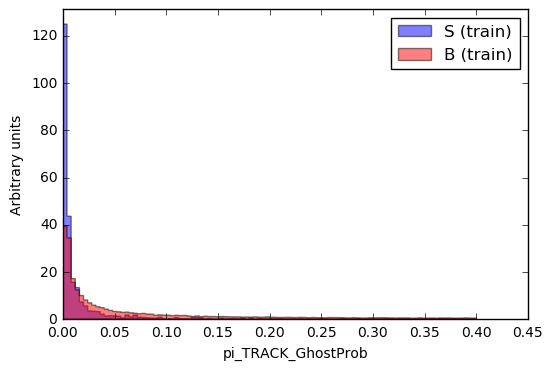

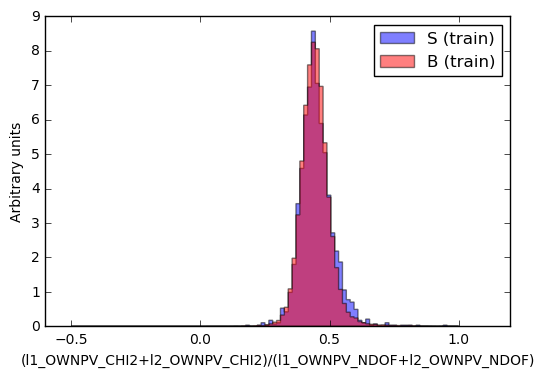

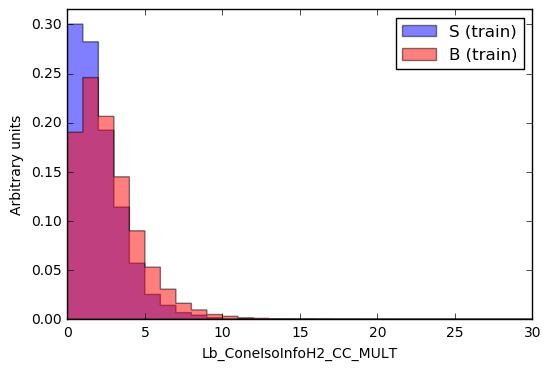

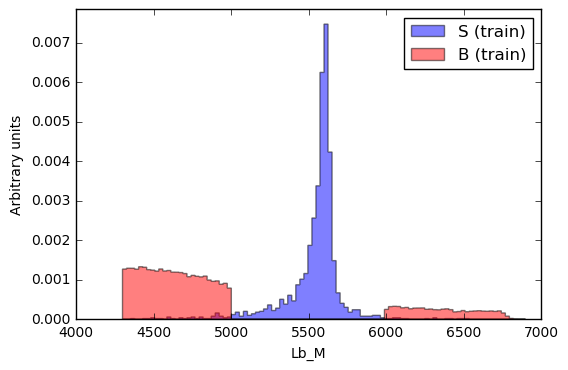

KeyError: 'eventNumber'

In [11]:
from tools.plot_sig_bkg import plot_sig_bkg
import imp
import sys
imp.reload (sys.modules['tools.plot_sig_bkg'])
for var in branches+additional_branches:
    plot_sig_bkg(train_data_signal_with_labels, train_data_background_with_labels, var, plots_dir, binning=vars_db[var]['binning'])


In [ ]:
import imp
import sys
from math import exp, log
#imp.reload (sys.modules['tools.features_selection'])
from tools.features_selection import entropy_normalised




scores = []
for branch in branches:
    res = entropy_normalised(train_data_signal_with_labels, train_data_background_with_labels, branch)
    scores.append(1./res['min entropy'])

branches_with_scores = pd.DataFrame(
    {'variable': branches,
     'score': scores,
    })

branches_with_scores=branches_with_scores.sort_values(by='score', ascending=False)

In [ ]:
bw = .5
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
pos = np.arange(5)+.5    # the bar centers on the y axis
ax.barh(range(len(branches_with_scores['variable'])),branches_with_scores['score'], align='center')
plt.yticks(range(len(branches_with_scores['variable'])), branches_with_scores['variable'])
plt.xlabel('Score')
plt.title(r'Input variables scores (entropy$^{-1}$)')
plt.tight_layout()
plt.ylim([-1,len(branches_with_scores['variable'])])
plt.gca().invert_yaxis() #otherwise it's lowest to highest
plt.savefig(plots_dir+"/scores.pdf") #replace is necessary for slashes, otherwise part of the name
plt.show()

In [ ]:
#training_variables
training_variables = []
for branch in vars_db:
    if (vars_db[branch]['in_MVA']):
        training_variables.append(branch)
n_vars=len(training_variables)
print n_vars, "used in the BDT:"
print "\n".join(training_variables)

In [ ]:
#now we have to change names to the input variables removing the mathematical symbols, otherwise tmva gets confused
branches = [var.replace("+","_mathPLUS_").replace("-","_mathMINUS_").replace("*","_mathTIMES_").replace("/","_mathOVER_") for var in branches]
training_variables = [var.replace("+","_mathPLUS_").replace("-","_mathMINUS_").replace("*","_mathTIMES_").replace("/","_mathOVER_") for var in training_variables]
train_data.columns = [var.replace("+","_mathPLUS_").replace("-","_mathMINUS_").replace("*","_mathTIMES_").replace("/","_mathOVER_") for var in train_data.columns]
test_data.columns = [var.replace("+","_mathPLUS_").replace("-","_mathMINUS_").replace("*","_mathTIMES_").replace("/","_mathOVER_") for var in test_data.columns]


In [ ]:
sys.stdout = default_stdout


#prepare normalised set for skMLP
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(train_data[training_variables])  
train_data_scaled = scaler.transform(train_data[training_variables])  
# apply same transformation to test data
test_data_scaled = scaler.transform(test_data[training_variables])  

scaled_training_variables = [var+"_scaled" for var in training_variables]
train_data_with_scaled_vars = pd.DataFrame(np.hstack((train_data, train_data_scaled.reshape(train_data_scaled.shape[0], -1))),
                  columns=(branches+additional_branches+scaled_training_variables))

test_data_with_scaled_vars = pd.DataFrame(np.hstack((test_data, test_data_scaled.reshape(test_data_scaled.shape[0], -1))),
                  columns=(branches+additional_branches+scaled_training_variables))



#re-do the dataframes with labels
train_data_with_scaled_vars_with_labels = pd.DataFrame(np.hstack((train_data_with_scaled_vars, train_labels.reshape(train_labels.shape[0], -1))),
                  columns=branches+additional_branches+scaled_training_variables+['labels'])
test_data_with_scaled_vars_with_labels = pd.DataFrame(np.hstack((test_data_with_scaled_vars, test_labels.reshape(test_labels.shape[0], -1))),
                  columns=branches+additional_branches+scaled_training_variables+['labels'])


In [ ]:
from math import floor
#The goal here is to optimise all the classifiers before comparing them

#So now we define grid search params for each classifier
grid_params = {} #empty dictionary (of dictionaries) of grid params
classifiers = {} #empty dictionary of classifiers

classifiers['xgboost Gradient Boosting'] = XGBoostClassifier(features=training_variables)
grid_params['xgboost Gradient Boosting'] = {}
grid_params['xgboost Gradient Boosting']['n_estimators'] = randint(50, 300)
#grid_params['xgboost Gradient Boosting']['gamma'] = randint(0, 1000) #minimum loss reduction required to make a further partition on a leaf node of the tree. The larger, the more conservative the algorithm will be.
grid_params['xgboost Gradient Boosting']['max_depth'] = randint(2,7)
grid_params['xgboost Gradient Boosting']['min_child_weight'] = randint(1,20)
grid_params['xgboost Gradient Boosting']['eta'] = uniform(0.01, 0.2) #learning rate

classifiers['scikit-learn Gradiend Boosting'] = SklearnClassifier(GradientBoostingClassifier(), features=training_variables)
grid_params['scikit-learn Gradiend Boosting'] = {}
grid_params['scikit-learn Gradiend Boosting']['loss'] = ['deviance', 'exponential']
grid_params['scikit-learn Gradiend Boosting']['n_estimators'] = randint(50, 300)
grid_params['scikit-learn Gradiend Boosting']['max_depth'] = randint(2,7)
grid_params['scikit-learn Gradiend Boosting']['learning_rate'] = uniform(0.01, 0.2)
#grid_params['scikit-learn Gradiend Boosting']['min_weight_fraction_leaf'] = uniform(0,0.05)


classifiers['TMVA kBDT'] = TMVAClassifier(method='kBDT', features=training_variables)
grid_params['TMVA kBDT'] = {}
grid_params['TMVA kBDT']['Ntrees'] = randint(400, 2500)
grid_params['TMVA kBDT']['MaxDepth'] = randint(2,7)
grid_params['TMVA kBDT']['MinNodeSize'] = ['0.2%', '0.3%', '0.5%', '1%', '2%', '3%']
grid_params['TMVA kBDT']['NCuts'] = randint(10,40)
grid_params['TMVA kBDT']['AdaBoostBeta'] = uniform(0.05, 0.4)

"""
classifiers['Theanets'] = TheanetsClassifier(features=training_variables)
#filling list of possible sized of layers for Theanets
list_layers_theanets = [] 

for i in range(10): #10 different random configurations for each lenght
    for i in range(1,10):
        layer = []#[len(training_variables)] # the firs element is the size of the input layer
        for j in range(i):
            layer.append(random.randint(300,500))
        list_layers_theanets.append(layer)
    
t = len(training_variables)

grid_params['Theanets'] = {}
grid_params['Theanets']['layers'] = [(t+1,), (t-1,), (t+2,), (t-2,), (t+1, t+2), (t-1, t-2),
                                     (floor(t/2),), (floor(t/2), floor(t/2)-1),
                                     (floor(t/2), floor(t/2)-2),
                                    (floor(t/2)+2, floor(t/2)-2)]#list_layers_theanets #layers configuration

grid_params['Theanets']['trainers']=[[{'learning_rate': 0.1, 'min_improvement': 0.1}],
                                    [{'learning_rate': 0.2, 'min_improvement': 0.1}],
                                    [{'learning_rate': 0.3, 'min_improvement': 0.1}],
                                    [{'learning_rate': 0.1, 'min_improvement': 0.2}],
                                    [{'learning_rate': 0.2, 'min_improvement': 0.2}],
                                    [{'learning_rate': 0.3, 'min_improvement': 0.2}],
                                    [{'learning_rate': 0.1, 'min_improvement': 0.3}],
                                    [{'learning_rate': 0.2, 'min_improvement': 0.3}],
                                    [{'learning_rate': 0.3, 'min_improvement': 0.3}],
                                    [{'learning_rate': 0.1, 'min_improvement': 0.4}],
                                    [{'learning_rate': 0.2, 'min_improvement': 0.4}],
                                    [{'learning_rate': 0.3, 'min_improvement': 0.4}]]
"""
classifiers['scikit-learn MLP'] = SklearnClassifier(MLPClassifier(), features=scaled_training_variables) #this needs the scaled variables
list_layers_skMLP = []
for k in range(5,50):
    for i in range(1,5):
        tuple_layer = ()
        kk=k
        for j in range(i):
            tuple_layer+=(kk,)
            kk = kk-1
        list_layers_skMLP.append(tuple_layer)     
        
grid_params['scikit-learn MLP'] = {}
#grid_params['skMLP']['activation'] = ['identity', 'logistic', 'tanh', 'relu']
grid_params['scikit-learn MLP']['solver'] = ['lbfgs', 'adam']#, 'sgd']
grid_params['scikit-learn MLP']['hidden_layer_sizes'] = list_layers_skMLP #hidden layer configuration
grid_params['scikit-learn MLP']['learning_rate_init'] = uniform(0.001, 0.2)
grid_params['scikit-learn MLP']['alpha'] = 10.0 ** -np.arange(1, 7)


# Using gradient boosting with default settings
#classifiers['GaussNB'] = SklearnClassifier(GaussianNB(), features=training_variables) #if I understand correctly this has only one parameter, which is better to leave free


In [ ]:
k=5 #number of folds

from tools.MyFoldingScorer import ClassificationFoldingScorer_no_overtrain
imp.reload (sys.modules['tools.MyFoldingScorer'])
from tools.MyFoldingScorer import ClassificationFoldingScorer_no_overtrain
from tools.auc_no_overtrain import auc_no_overtrain
import datetime
#.strftime("%Y-%m-%d_%H:%M:%S")
    
#for each estimator, run the grid search
grid_finder = {}


for classifier in classifiers:
    if classifier is 'GaussNB': continue #GaussNB doesn't need to be optimised
 
    sys.stdout = open(output_dir+'/stdout_{0}.txt'.format(classifier), 'w')
    now = datetime.datetime.now()
    print now
    generator = RandomParameterOptimizer(grid_params[classifier], n_evaluations=20)
    estimator = classifiers[classifier]
    scorer = ClassificationFoldingScorer_no_overtrain(RocAuc(), folds=k)
    grid_finder[classifier] = GridOptimalSearchCV(estimator, generator, scorer, parallel_profile='threads-2')
    grid_finder[classifier].fit(train_data_with_scaled_vars, train_labels)
    sys.stdout = open(output_dir+'/scores_{1}.txt'.format(tag, classifier), 'w')
    now = datetime.datetime.now()
    print now
    grid_finder[classifier].params_generator.print_results()
    
sys.stdout = default_stdout


In [ ]:
for classifier in classifiers:
    print "Results of grid scan for", classifier, ":"
    grid_finder[classifier].generator.print_results()
    print "\n ========================================== \n"

In [18]:
#set best parameters on all untrained classifiers
for classifier in classifiers:
    classifiers[classifier].set_params(**grid_finder[classifier].generator.best_params_)
    classifiers[classifier].features=None #this is needed for the FoldingClassifiers, that wants to se the features himself

In [19]:
#now train all these classifiers with k-folding again
sys.stdout = default_stdout

#get report object, containing the info about performances
from rep.metaml import ClassifiersFactory

folder = {}
factory = ClassifiersFactory()
for classifier in classifiers:
    ft = scaled_training_variables if (classifier == 'scikit-learn MLP') else training_variables
    print "Training ", classifier, "..."
    folder[classifier] = FoldingClassifier(classifiers[classifier], n_folds=k, features=ft)
    folder[classifier].fit(train_data_with_scaled_vars , train_labels) #fit on train data now!
    factory.add_classifier(classifier, folder[classifier])
    print ">>> done!"

report = factory.test_on(test_data_with_scaled_vars, test_labels) #rocs drawn on validation sample

Training  scikit-learn Gradiend Boosting ...
>>> done!
Training  xgboost Gradient Boosting ...
>>> done!
Training  TMVA kBDT ...
DataSetInfo              : [./] : Added class "Signal"
DataSetInfo              : [./] : Added class "Background"
                         : Add Tree TrainAssignTree_Signal of type Signal with 1547 events
                         : Add Tree TestAssignTree_Signal of type Signal with 1547 events
                         : Add Tree TrainAssignTree_Background of type Background with 2046 events
                         : Add Tree TestAssignTree_Background of type Background with 2046 events
                         : Dataset[./] : Class index : 0  name : Signal
                         : Dataset[./] : Class index : 1  name : Background
Factory                  : Booking method: REP_Estimator
                         : 
DataSetFactory           : [./] : Number of events in input trees
                         : Dataset[./] :     Signal     requirement: "1"
       

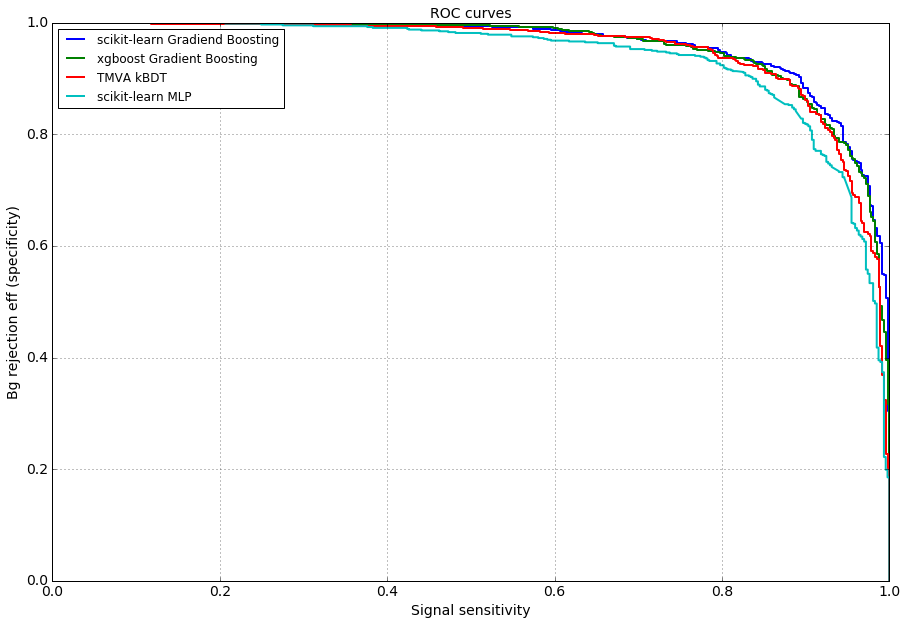

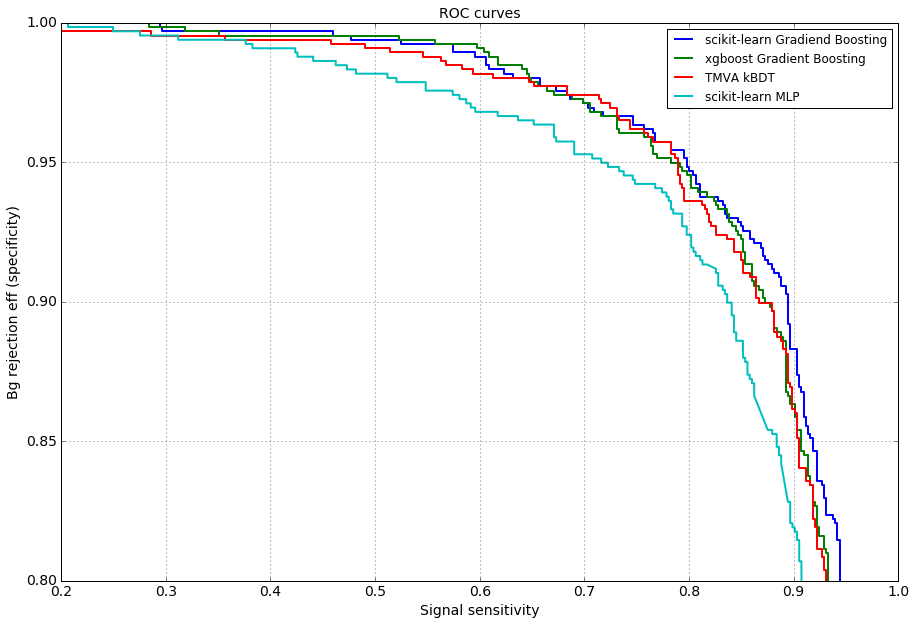

In [20]:
#plot roc curves
fig = plt.figure(figsize=(15,10))
report.roc(physics_notion=True).plot(xlim=(0, 1), ylim=(0, 1))
plt.savefig(plots_dir+"/rocs_all.pdf")
plt.show()


fig = plt.figure(figsize=(15,10))
report.roc(physics_notion=True).plot(xlim=(0.2, 1), ylim=(0.8, 1))
plt.savefig(plots_dir+"/rocs_all_zoommed.pdf")
plt.show()

In [21]:
#Put back the features and save un-trained classifiers
import pickle

for classifier in classifiers:
    classifiers[classifier].features=training_variables

for classifier in classifiers:
    file_name = classifiers_dir+classifier+"_emu_"+str(tag)+".pickle.dat"
    if os.path.exists(file_name):
        os.remove(file_name)
    pickle.dump(classifiers[classifier], open(file_name, "wb"))